In [16]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt 
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator 
import seaborn as sns
import os
import tensorflow
from shutil import copyfile

import os
for dirname, _, filenames in os.walk(os.getcwd()+'/dogs-vs-cats'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/mnt/c/Users/AnitChakraborty/Videos/dogs-vs-cats/sampleSubmission.csv
/mnt/c/Users/AnitChakraborty/Videos/dogs-vs-cats/test1.zip
/mnt/c/Users/AnitChakraborty/Videos/dogs-vs-cats/train.zip


In [4]:
import zipfile

zip_ref = zipfile.ZipFile('/mnt/c/Users/AnitChakraborty/Videos/dogs-vs-cats/train.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [5]:
zip_ref = zipfile.ZipFile('/mnt/c/Users/AnitChakraborty/Videos/dogs-vs-cats/test1.zip', 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
print(len(os.listdir("/tmp/train")))
os.listdir("/tmp/train")[0]
print(len(os.listdir("/tmp/test1/")))
os.listdir("/tmp/test1/")[0]

25000
12500


'1.jpg'

In [7]:
base_path = '/tmp/'

train_path = base_path + 'train'

test_path = base_path +'test1'

In [8]:
filenames = os.listdir(train_path)
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

df["category"] = df["category"].replace({0: 'cat', 1: 'dog'})
df.head()

filename category
0     cat.0.jpg      cat
1     cat.1.jpg      cat
2    cat.10.jpg      cat
3   cat.100.jpg      cat
4  cat.1000.jpg      cat

Text(0.5, 0, 'cat')

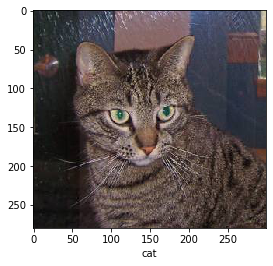

In [12]:
image = load_img(train_path +"/"+ df['filename'].iloc[1])
plt.imshow(image)
plt.xlabel(df['category'].iloc[1])

In [13]:
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Dropout,BatchNormalization,Flatten
from tensorflow.keras.models import Sequential,Model

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [14]:
from tensorflow.keras.optimizers import RMSprop


model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

from sklearn.model_selection import train_test_split


train_df, validation_df = train_test_split(df, test_size=0.15)
train_df = train_df.reset_index(drop=True)
validation_df = validation_df.reset_index(drop=True)

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='binary',
    batch_size=64
)

validation_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df, 
    train_path, 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='binary',
    batch_size=64
)


Found 21250 validated image filenames belonging to 2 classes.
Found 3750 validated image filenames belonging to 2 classes.


In [15]:
class myCallback(tensorflow.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.95):
      print("\nReached loss less than 1 so cancelling training!")
      self.model.stop_training = True
        
        
call_back = myCallback()

history = model.fit_generator(
    train_generator, 
    epochs=15,
    validation_data=validation_generator,
    validation_steps=validation_df.shape[0]//64,
    steps_per_epoch=train_df.shape[0]//64,
    callbacks = [call_back]
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/15
332/332 [==============================] - 926s 3s/step - loss: 0.7064 - accuracy: 0.6210 - val_loss: 0.6021 - val_accuracy: 0.6581
Epoch 2/15
332/332 [==============================] - 531s 2s/step - loss: 0.5625 - accuracy: 0.7104 - val_loss: 0.5003 - val_accuracy: 0.7540
Epoch 3/15
332/332 [==============================] - 530s 2s/step - loss: 0.5213 - accuracy: 0.7445 - val_loss: 0.4790 - val_accuracy: 0.7691
Epoch 4/15
332/332 [==============================] - 549s 2s/step - loss: 0.4867 - accuracy: 0.7670 - val_loss: 0.4892 - val_accuracy: 0.7635
Epoch 5/15
332/332 [==============================] - 542s 2s/step - loss: 0.4684 - accuracy: 0.7764 - val_loss: 0.4947 - val_accuracy: 0.7492
Epoch 6/15
332/332 [==============================] - 515s 2s/step - loss: 0.4555 - accuracy: 0.7864 - val_loss: 0.4350 - val_accuracy: 0.7969
Epoch 7/15
332/332 [==============================] - 529s 2s/step

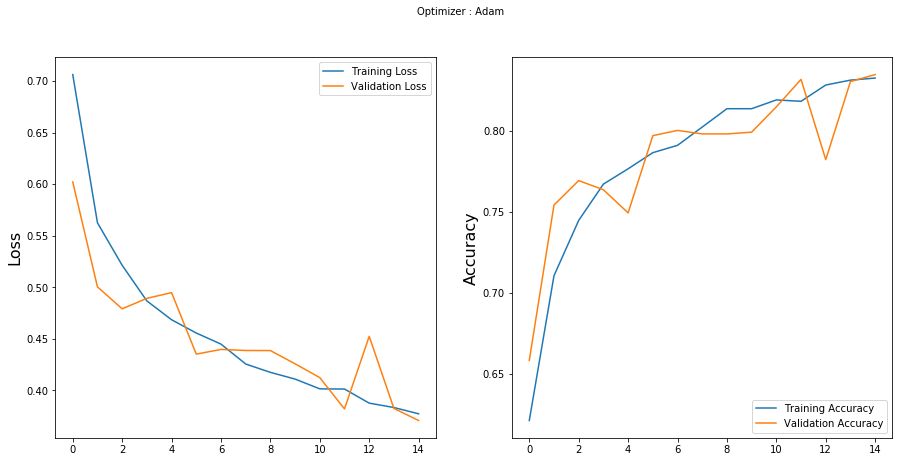

In [17]:
# plot the evolution of Loss and Acuracy on the train and validation sets
plt.figure(figsize=(15,7))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [18]:
model.save_weights("model.h5")

# serialize model structure to JSON

model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [19]:
test_filenames = os.listdir(test_path)
test_df = pd.DataFrame({
    'filename': test_filenames
})
test_samples = test_df.shape[0]
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    test_path, 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=(150,150),
    batch_size=15,
    shuffle=False
)
predict = model.predict_generator(test_generator, steps=np.ceil(test_samples/15))

Found 12500 validated image filenames.
Instructions for updating:
Please use Model.predict, which supports generators.


In [27]:
test_df['category'] = np.argmax(predict, axis=-1)
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)
classes = ["cat",'dog']
sample_test = test_df.head(9)
sample_test.head()

filename category
0      1.jpg      cat
1     10.jpg      cat
2    100.jpg      cat
3   1000.jpg      cat
4  10000.jpg      cat

TypeError: list indices must be integers or slices, not str

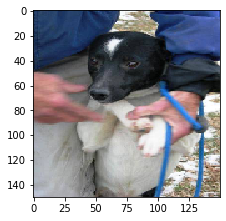

In [28]:
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img(test_path + "/" + filename, target_size=(150,150))
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel('---' + "{}".format(classes[category] ) + '----',fontsize = 18)
plt.tight_layout()
plt.show()

In [29]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)